### INTRO 

In [1]:
import re
import time
import subprocess
import itertools
import cPickle as pickle
import numpy as np
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as hcluster
import pandas as pd
import collections as cl
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import pprint
pp = pprint.PrettyPrinter(indent=2)

In [2]:
from lib.py_rabin import rabin_partition, example_rabin_partition
from IPython.core.debugger import Tracer
%matplotlib inline
%load_ext cythonmagic
%load_ext line_profiler

/Users/ivlahinic/anaconda2/lib/python2.7/site-packages/IPython/extensions/cythonmagic.py:21: UserWarning: The Cython magic has been moved to the Cython package
  warnings.warn("""The Cython magic has been moved to the Cython package""")


### Load two example English language documents:
1. template
2. another from same cluster 

In [7]:
%%time
#df = pd.read_pickle('contract_data/openland_contracts_with_text.pkl') # ~200 
df = pd.read_pickle('contract_data/resource_contracts_with_text.pkl') # ~1500
df.columns = [k.lower().replace(" ","_") for k in df.columns]

CPU times: user 142 ms, sys: 226 ms, total: 368 ms
Wall time: 375 ms


In [67]:
dfc = pd.read_csv("results_clustering/resource_contracts_with_text_templates.csv")
dfc = dfc[(dfc.country_name=="Tunisia")]
dfc

,Unnamed: 0,ocid,category,contract_name,contract_identifier,language,country_name,resource,contract_type,signature_date,...,Level_04,Level_05,Level_06,Level_00_template,Level_01_template,Level_02_template,Level_03_template,Level_04_template,Level_05_template,Level_06_template
73,73,ocds-591adf-5848991193,rc,"Tunisia, ETAP, APEX, EUROGAS, Sfax Offshore P...",Tunisia_Safx-offshore_dd20050720_Convention,en,Tunisia,Hydrocarbons,Concession Agreement;Translated Contract,2005-07-20,...,0.0.4.1.1,0.0.4.1.1,0.0.4.1.1,False,False,False,False,False,False,False
74,74,ocds-591adf-3419068261,rc,L'Entreprise Tunisienne D'Activit�s Petroliere...,NaN,fr,Tunisia,Hydrocarbons,Concession Agreement,2005-09-09,...,4.0.0.2,4.0.0.2,4.0.0.2,False,False,False,False,False,False,False
75,75,ocds-591adf-5834131316,rc,L'Entreprise Tunisienne D'Activit�s Petroliere...,NaN,fr,Tunisia,Hydrocarbons,Concession Agreement;Contract Amendment,2013-02-15,...,4.1.0.1.1,4.1.0.1.1.0,4.1.0.1.1.0,False,False,False,False,False,False,False
76,76,ocds-591adf-8560734374,rc,"Tunisia, ETAP, APEX, EUROGAS, Sfax, PSC, 2005",Tunisia_Safx-offshore_dd20050720_PSC,en,Tunisia,Hydrocarbons,Production or Profit Sharing Agreement;Transla...,2005-07-20,...,0.0.0.1.1,0.0.0.1.1,0.0.0.1.1,False,False,False,False,False,False,False
185,185,ocds-591adf-0358603254,rc,"ETAP, OMV, Nawara, Concession Avenant N�1 - Tu...",NaN,fr,Tunisia,Hydrocarbons,Concession Agreement;Contract Amendment,2005-05-26,...,4.1.0.3.0,4.1.0.3.0.0,4.1.0.3.0.0,False,False,False,False,False,False,False
186,186,ocds-591adf-4712380251,rc,"ETAP, OMV, Nawara, Joint Venture - Tunisia, 2003",NaN,fr,Tunisia,Hydrocarbons,Joint Venture Agreement,2003-11-10,...,4.1.1.0,4.1.1.0,4.1.1.0,False,False,False,False,False,False,False
192,192,ocds-591adf-0624472233,rc,"ETAP, YNG, Concession Permis Araifa - Tunisia,...",NaN,fr,Tunisia,Hydrocarbons,Concession Agreement,2013-03-07,...,4.0.0.1,4.0.0.1,4.0.0.1,False,False,False,False,False,False,False
193,193,ocds-591adf-1406548730,rc,Contrat de partage de production Jenein Centre,NaN,fr,Tunisia,Hydrocarbons,Production or Profit Sharing Agreement,2009-10-05,...,4.1.2,4.1.2,4.1.2,False,True,False,False,False,False,False
194,194,ocds-591adf-5025757871,rc,"ETAP, Storm Ventures, Concession Permis Jenein...",NaN,fr,Tunisia,Hydrocarbons,Concession Agreement,2009-10-05,...,4.0.0.0,4.0.0.0,4.0.0.0,False,False,False,False,False,False,False
195,195,ocds-591adf-2236979409,rc,"ETAP, DUALEX, Concession Bouhajla - Tunisia, 2009",NaN,fr,Tunisia,Hydrocarbons,Concession Agreement,2009-09-11,...,4.0.0.0,4.0.0.0,4.0.0.0,False,False,True,False,False,False,False


In [84]:
# remove other characters
## char_to_remove = set(['.',',',';',':','-','_','[',']','&','`','@','*','^','|','~',';',':','\'','\"',">","<"]) 
char_to_remove = []
def longstr_clean(longstr):
    longstr = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', longstr) # remove all non-printable characters
    longstr = re.compile(r'<.*?>').sub('', longstr) # strip html markup, e.g. <br>,<div>, etc...
    longstr = longstr.replace("&nbsp",'').replace("&lt;",'').replace("&gt;",'').replace("\\",'') 
    longstr = "".join(i for i in longstr if ord(i)<128 and i not in char_to_remove)
    longstr = longstr.replace('\r',' ').replace('\n',' ').replace('\t',' ')
    longstr = longstr.replace(";",".").replace(":",".")
    longstr = " ".join(longstr.split()) # remove whitespace
    return longstr

In [127]:
import spacy
nlp = spacy.load('en')

id1 = "ocds-591adf-3419068261"
doc1 = df.contract_text[df.ocid==id1].apply(longstr_clean).iloc[0]
doc1 = nlp(unicode(doc1, "utf-8"))

id2 = "ocds-591adf-5834131316"
doc2 = df.contract_text[df.ocid==id2].apply(longstr_clean).iloc[0]
doc2 = nlp(unicode(doc2, "utf-8"))

In [128]:
doc1.similarity(doc2)

0.94298750250071706

In [133]:
from fuzzywuzzy import process
sents1 = [k for k in doc1.sents] # NEW DOC/TARGET
sents2 = [k for k in doc2.sents] # TEMPLATE/MODEL

lfuzz = []
# LOOP ALL TARGET SENTENCE
for sent in sents1:
    
    # DONT CHECK SMALL SENTENCES
    if len(str(sent))<10: continue
        
    ## COMPARE A TARGET SENTENCE TO ALL SENTENCES IN MODEL
    ## ... AND OUTPUT CLOSEST MATCH
    out = process.extractOne(str(sent), sents2)
    
    ## BETTER APPROACH
    ## BEFORE COUNT VECTORIZER OR TFIDF, perhaps do spell check (english, spanish, french...)
    sent_tfidf = ... # Step 1vector
    model_sents_tfidf_ = # STep 2matrix
        # ---> Step 3. extract closest row based on "cosine distance" 
        #         from matrix sentence/phrase in model document most similar to target document sentence
        # ---> CATEGORIZE: 
    
    lfuzz.append(out[1])
    if out[1]==90:
        print("{}".format(out[1]))
        print("query: {}".format(str(sent)))
        print("match: {}".format(out[0]))
        print("")

90
query: ET EUROGAS INTERNATIONAL INC.
match: et EUROGAS

90
query: Tunis Juillet 2005
match: 2005.

90
query: I TRAVAUX DE RECHERCHE ARTICLE 2 Delimitation du Permis......................................................................................
match: Article 2 .

90
query: du Permis...........................................................................................
match: du Permis de Recherche Sfax Offshore a t publi 3U JORT

90
query: DE LENTREPRENEUR
match: Entrep....

90
query: Page ARTICLE 17
match: le

90
query: a la demande de TENTREPRENEUR.................................
match: Entrep....

90
query: 29 ARTICLE 22 Dispositions applicables aux captages
match: Article 2 .

90
query: 29 ARTICLE 23 Dispositions applicables aux voies ferrees........................................................
match: Article 2 .

90
query: 30 ARTICLE 24 Dispositions applicables aux installations de chargement
match: Article 2 .

90
query: 31 ARTICLE 25 Dispositions applicables au

KeyboardInterrupt: 

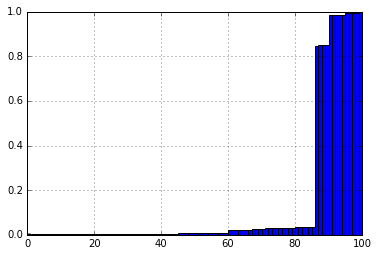

In [130]:
pd.Series(lfuzz).hist(cumulative=True, normed=1, bins=100)